In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import haversine as hs   
from haversine import Unit, haversine_vector
from shapely import Point, LineString, Polygon
import geopandas as gpd
import folium
import branca
import plotly.express as px
from geojson import Feature, FeatureCollection
from IPython.display import Image
from scipy.spatial.distance import jensenshannon

In [2]:
# Load data
df_real = pd.read_csv(
    "../data/train_small_cleaned.csv",
)

In [3]:
df_synthetic = pd.read_csv(
    "../data/train_small_synthetic_cleaned.csv",
)
df_synthetic = df_synthetic.sample(frac=0.5, random_state=42).reset_index(drop=True)

In [4]:
df_real = df_real.sample(df_synthetic.shape[0])

In [5]:
df_real.shape, df_synthetic.shape

((78603, 8), (78603, 7))

In [6]:
def plot_trips(df, n=100, color="blue", location=[41.17251, -8.61669], zoom_start=12):
    m = folium.Map(
        location=location,
        zoom_start=zoom_start,
        tiles="cartodbpositron",
        width=400,
        height=400,
    )

    for i, row in df.sample(n).iterrows():
        folium.PolyLine(
            locations=[[p[0], p[1]] for p in eval(row["POLYLINE"])],
            color=color,
            weight=3,
            opacity=0.6,
        ).add_to(m)

    return m

In [7]:
# Real trips
subplot_real = plot_trips(df_real, n=100, color="green")

# Synthetic trips
subplot_synthetic = plot_trips(df_synthetic, n=100, color="orange")

fig = branca.element.Figure(width=900, height=420, title="Real vs Synthetic Trips")
subplot1 = fig.add_subplot(1, 2, 1, margin=0.02)
subplot2 = fig.add_subplot(1, 2, 2, margin=0.02)
subplot1.add_child(subplot_real)
subplot2.add_child(subplot_synthetic)
fig

In [8]:
center_location = [41.15793, -8.62917]
zoom = 16

# Real trips
subplot_real = plot_trips(df_real, n=100, color="green", location=center_location, zoom_start=zoom)

# Synthetic trips
subplot_synthetic = plot_trips(df_synthetic, n=100, color="orange", location=center_location, zoom_start=zoom)

fig = branca.element.Figure(width=900, height=420, title="Real vs Synthetic Trips")
subplot1 = fig.add_subplot(1, 2, 1, margin=0.02)
subplot2 = fig.add_subplot(1, 2, 2, margin=0.02)
subplot1.add_child(subplot_real, name="Real Trips")
subplot2.add_child(subplot_synthetic, name="Synthetic Trips")
fig

## Accuracy on Location-Level

In [9]:
# Store all positions in a single array
all_coordinates_real = df_real["POLYLINE"].values
all_coordinates_real = [eval(x) for x in all_coordinates_real]
all_coordinates_real = [item for sublist in all_coordinates_real for item in sublist]
all_coordinates_real = np.array(all_coordinates_real)
df_all_coordinates_real = pd.DataFrame(all_coordinates_real, columns=["lat", "lon"])

all_coordinates_synthetic = df_synthetic["POLYLINE"].values
all_coordinates_synthetic = [eval(x) for x in all_coordinates_synthetic]
all_coordinates_synthetic = [item for sublist in all_coordinates_synthetic for item in sublist]
all_coordinates_synthetic = np.array(all_coordinates_synthetic)
df_all_coordinates_synthetic = pd.DataFrame(all_coordinates_synthetic, columns=["lat", "lon"])

In [10]:
N_HEGXAGONS_HORIZONTAL = 100

fig_real = ff.create_hexbin_mapbox(
    data_frame=df_all_coordinates_real, lat="lat", lon="lon",
    nx_hexagon=N_HEGXAGONS_HORIZONTAL, opacity=0.7, labels={"color": "Point Count"},
    min_count=1, 
    color_continuous_scale="turbo", # OrRd
    # show_original_data=True,
    # original_data_marker=dict(size=2, opacity=0.2, color="deeppink")
)
# fig_real.update_layout(mapbox_style="carto-positron")
# fig_real.show()

fig_synthetic = ff.create_hexbin_mapbox(
    data_frame=df_all_coordinates_synthetic, lat="lat", lon="lon",
    nx_hexagon=N_HEGXAGONS_HORIZONTAL, opacity=0.7, labels={"color": "Point Count"},
    min_count=1,
    color_continuous_scale="turbo", # OrRd
    # show_original_data=True,
    # original_data_marker=dict(size=2, opacity=0.2, color="deeppink")
)
# fig_synthetic.update_layout(mapbox_style="carto-positron")
# fig_synthetic.show()

In [11]:
# Create dataframe with all hexagons and their number of points in it
coordinates = [feature['geometry']['coordinates'] for feature in fig_real.data[0].geojson['features']]
coordinates = np.array(coordinates)[:,0]
coordinates = np.array([[[x[1], x[0]] for x in y] for y in coordinates])
values = fig_real.data[0]['z']
hexbins_df = pd.DataFrame({'coordinates': list(coordinates), 'n_points_real': values})
hexbins_df['n_points_real'] = hexbins_df['n_points_real'].astype(int)
hexbins_df['geometry'] = hexbins_df['coordinates'].apply(lambda x: LineString(x))

hexbins_gdf = gpd.GeoDataFrame(hexbins_df, geometry='geometry')
hexbins_gdf['centroid'] = hexbins_gdf['geometry'].centroid
hexbins_df['centroid'] = hexbins_gdf['centroid']
hexbins_df['centroid-lat'] = hexbins_df['centroid'].apply(lambda x: x.x)
hexbins_df['centroid-lon'] = hexbins_df['centroid'].apply(lambda x: x.y)

In [12]:
hexbins_df.sample(5)

,coordinates,n_points_real,geometry,centroid,centroid-lat,centroid-lon
5434,"[[41.10835336897357, -8.511499304841395], [41....",4,LINESTRING (41.10835336897357 -8.5114993048413...,POINT (41.10952 -8.51150),41.109523,-8.511499
3515,"[[41.241530840385266, -8.64322159510484], [41....",1,LINESTRING (41.241530840385266 -8.643221595104...,POINT (41.24270 -8.64322),41.242698,-8.643222
4387,"[[41.14342632133563, -8.589457394997313], [41....",216,LINESTRING (41.14342632133563 -8.5894573949973...,POINT (41.14460 -8.58946),41.144595,-8.589457
3963,"[[41.210013278380856, -8.616339495051077], [41...",43,LINESTRING (41.210013278380856 -8.616339495051...,POINT (41.21118 -8.61634),41.211181,-8.616339
2906,"[[41.20300731274528, -8.696985795212369], [41....",101,LINESTRING (41.20300731274528 -8.6969857952123...,POINT (41.20418 -8.69699),41.204175,-8.696986


In [13]:
# Classify the number of points in 3 categories: hot-spots (top 1%), frequently-visted (top 2-10%), and less-visited (bottom 90%)
hexbins_df['n_points_real_category'] = pd.qcut(hexbins_df['n_points_real'], q=[0, 0.9, 0.99, 1], labels=["less-visited", "frequently-visited", "hot-spots"])

In [14]:
# Add number of points in synthetic data to most N visited hexagons
def count_points_in_hexagon(hexagon, points):
    polygon = Polygon(hexagon)
    return sum([Point(x).covered_by(polygon) for x in points])

TOP_N_PLACES = 50
top_n_hexagons_df = hexbins_df.copy()
top_n_hexagons_df = top_n_hexagons_df.sort_values('n_points_real', ascending=False).head(TOP_N_PLACES)
all_coordinates_synthetic_copy = all_coordinates_synthetic.copy()
top_n_hexagons_df['n_points_synthetic'] = top_n_hexagons_df['coordinates'].apply(lambda x: count_points_in_hexagon(x, all_coordinates_synthetic_copy))

In [15]:
# Add relative frequency of real and synthetic points
top_n_hexagons_df['n_points_real_relative'] = top_n_hexagons_df['n_points_real'] / all_coordinates_real.shape[0]
top_n_hexagons_df['n_points_synthetic_relative'] = top_n_hexagons_df['n_points_synthetic'] / all_coordinates_synthetic.shape[0]

In [16]:
top_n_hexagons_df.head(5)

,coordinates,n_points_real,geometry,centroid,centroid-lat,centroid-lon,n_points_real_category,n_points_synthetic,n_points_real_relative,n_points_synthetic_relative
4037,"[[41.14693258550016, -8.610963075040324], [41....",46537,LINESTRING (41.14693258550016 -8.6109630750403...,POINT (41.14810 -8.61096),41.148101,-8.610963,hot-spots,45766,0.012031,0.011823
4080,"[[41.14693258550016, -8.608274865034947], [41....",42692,LINESTRING (41.14693258550016 -8.6082748650349...,POINT (41.14810 -8.60827),41.148101,-8.608275,hot-spots,41305,0.011037,0.010671
1183,"[[41.14517947685271, -8.612307180043013], [41....",42547,LINESTRING (41.14517947685271 -8.6123071800430...,POINT (41.14635 -8.61231),41.146348,-8.612307,hot-spots,42749,0.010999,0.011044
4036,"[[41.14342632133563, -8.610963075040324], [41....",33154,LINESTRING (41.14342632133563 -8.6109630750403...,POINT (41.14460 -8.61096),41.144595,-8.610963,hot-spots,32705,0.008571,0.008449
4433,"[[41.14693258550016, -8.586769184991935], [41....",32151,LINESTRING (41.14693258550016 -8.5867691849919...,POINT (41.14810 -8.58677),41.148101,-8.586769,hot-spots,32253,0.008312,0.008332


In [17]:
# swap lat and lon for plotly
top_n_hexagons_df['polygons_plotly'] = top_n_hexagons_df['coordinates'].apply(lambda x: Polygon([[y[1], y[0]] for y in x]))
top_n_hexagons_df['index'] = top_n_hexagons_df.index

In [18]:
def hexagons_dataframe_to_geojson(df_hex, hex_id_field, geometry_field, value_field):
    list_features = []

    for i, row in df_hex.iterrows():
        feature = Feature(geometry = row[geometry_field],
                          id = row[hex_id_field],
                          properties = {"value": row[value_field]})
        list_features.append(feature)

    feature_collection = FeatureCollection(list_features)

    return feature_collection

geojson_real = hexagons_dataframe_to_geojson(top_n_hexagons_df, 'index', 'polygons_plotly', 'n_points_real')
geojson_synthetic = hexagons_dataframe_to_geojson(top_n_hexagons_df, 'index', 'polygons_plotly', 'n_points_synthetic')

In [19]:
top_n_hexagons_df.head(5)

,coordinates,n_points_real,geometry,centroid,centroid-lat,centroid-lon,n_points_real_category,n_points_synthetic,n_points_real_relative,n_points_synthetic_relative,polygons_plotly,index
4037,"[[41.14693258550016, -8.610963075040324], [41....",46537,LINESTRING (41.14693258550016 -8.6109630750403...,POINT (41.14810 -8.61096),41.148101,-8.610963,hot-spots,45766,0.012031,0.011823,POLYGON ((-8.610963075040324 41.14693258550016...,4037
4080,"[[41.14693258550016, -8.608274865034947], [41....",42692,LINESTRING (41.14693258550016 -8.6082748650349...,POINT (41.14810 -8.60827),41.148101,-8.608275,hot-spots,41305,0.011037,0.010671,POLYGON ((-8.608274865034947 41.14693258550016...,4080
1183,"[[41.14517947685271, -8.612307180043013], [41....",42547,LINESTRING (41.14517947685271 -8.6123071800430...,POINT (41.14635 -8.61231),41.146348,-8.612307,hot-spots,42749,0.010999,0.011044,POLYGON ((-8.612307180043013 41.14517947685271...,1183
4036,"[[41.14342632133563, -8.610963075040324], [41....",33154,LINESTRING (41.14342632133563 -8.6109630750403...,POINT (41.14460 -8.61096),41.144595,-8.610963,hot-spots,32705,0.008571,0.008449,POLYGON ((-8.610963075040324 41.14342632133563...,4036
4433,"[[41.14693258550016, -8.586769184991935], [41....",32151,LINESTRING (41.14693258550016 -8.5867691849919...,POINT (41.14810 -8.58677),41.148101,-8.586769,hot-spots,32253,0.008312,0.008332,POLYGON ((-8.586769184991935 41.14693258550016...,4433


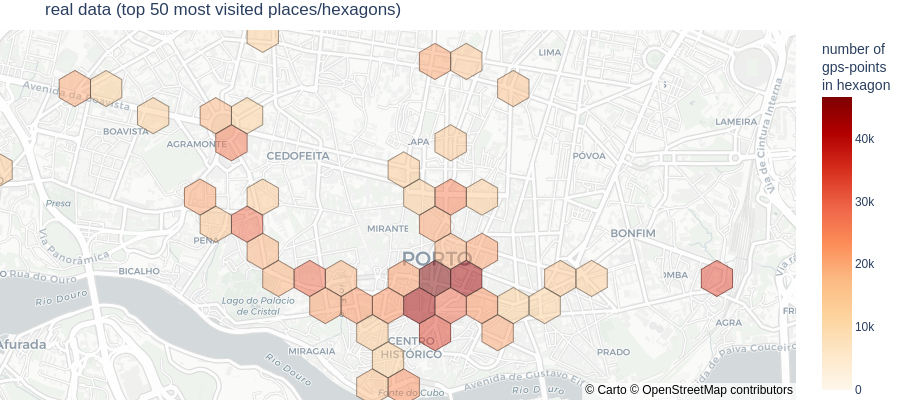

In [20]:
fig_hexa_real = px.choropleth_mapbox(
    top_n_hexagons_df, geojson=geojson_real, locations='index', color='n_points_real',
    color_continuous_scale="OrRd", # OrRd
    range_color=(0, top_n_hexagons_df['n_points_real'].max()),
    mapbox_style="carto-positron",
    zoom=13, center = {"lat": 41.15220, "lon": -8.61414},
    opacity=0.5,
    labels={'n_points_real':'number of<br>gps-points<br>in hexagon'},
    title=f'real data (top {TOP_N_PLACES} most visited places/hexagons)',
    width=900,
    height=400,
)
fig_hexa_real.update_layout(margin=dict(b=0, t=30, l=0, r=0))
fig_hexa_real.update_traces(hovertemplate='%{z}')
# fig_hexa_real.show()
png_hexa_real = fig_hexa_real.to_image(format="png", width=900, height=400, scale=1)
Image(png_hexa_real)

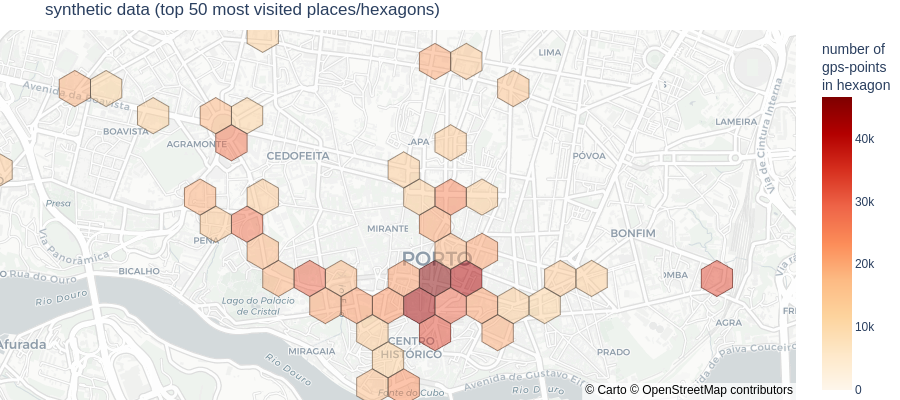

In [21]:
fig_hexa_sythetic = px.choropleth_mapbox(
    top_n_hexagons_df, geojson=geojson_synthetic, locations='index', color='n_points_synthetic',
    color_continuous_scale="OrRd", # OrRd
    range_color=(0, top_n_hexagons_df['n_points_real'].max()),
    mapbox_style="carto-positron",
    zoom=13, center = {"lat": 41.15220, "lon": -8.61414},
    opacity=0.5,
    labels={'n_points_synthetic':'number of<br>gps-points<br>in hexagon'},
    title=f'synthetic data (top {TOP_N_PLACES} most visited places/hexagons)',
    width=900,
    height=400,
)
fig_hexa_sythetic.update_layout(margin=dict(b=0, t=30, l=0, r=0))
fig_hexa_sythetic.update_traces(hovertemplate='%{z}')
# fig_hexa_sythetic.show()
png_hexa_sythetic = fig_hexa_sythetic.to_image(format="png", width=900, height=400, scale=1)
Image(png_hexa_sythetic)

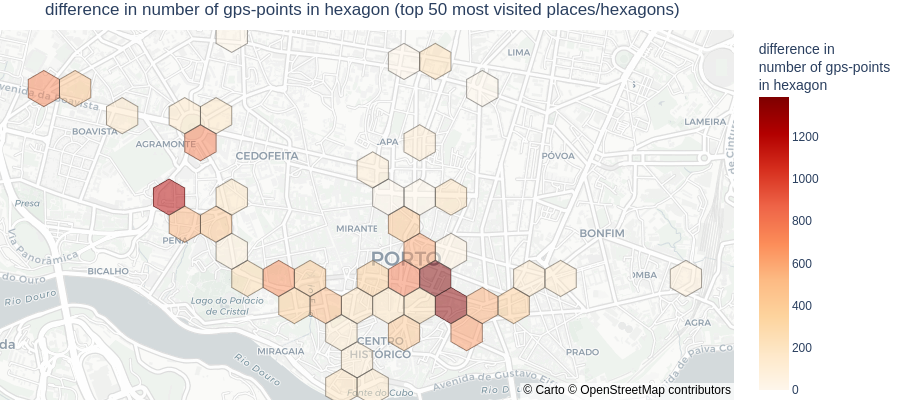

In [22]:
top_n_hexagons_df['n_points_diff'] = (top_n_hexagons_df['n_points_real'] - top_n_hexagons_df['n_points_synthetic']).abs()
fig_hexa_diff = px.choropleth_mapbox(
    top_n_hexagons_df, geojson=geojson_real, locations='index', color='n_points_diff',
    color_continuous_scale="OrRd", # OrRd
    range_color=(0, top_n_hexagons_df['n_points_diff'].max()),
    mapbox_style="carto-positron",
    zoom=13, center = {"lat": 41.15220, "lon": -8.61414},
    opacity=0.5,
    labels={'n_points_diff':'difference in<br>number of gps-points<br>in hexagon'},
    title=f'difference in number of gps-points in hexagon (top {TOP_N_PLACES} most visited places/hexagons)',
    width=900,
    height=400,
)
fig_hexa_diff.update_layout(margin=dict(b=0, t=30, l=0, r=0))
fig_hexa_diff.update_traces(hovertemplate='%{z}')
# fig_hexa_diff.show()
png_hexa_diff = fig_hexa_diff.to_image(format="png", width=900, height=400, scale=1)
Image(png_hexa_diff)

In [23]:
# Plot frequency of top N visited places (hexagons) - Real vs Synthetic
top_n_hexagons_df = top_n_hexagons_df.sort_values('n_points_real', ascending=False).reset_index()
top_n_hexagons_df['n_hexagon'] = top_n_hexagons_df.index
top_n_hexagons_df_chart = pd.melt(top_n_hexagons_df, id_vars=['n_hexagon'], value_vars=['n_points_real_relative', 'n_points_synthetic_relative'], var_name='data', value_name='n_points')
top_n_hexagons_df_chart['data'] = top_n_hexagons_df_chart['data'].apply(lambda x: 'Real' if x == 'n_points_real_relative' else 'Synthetic')

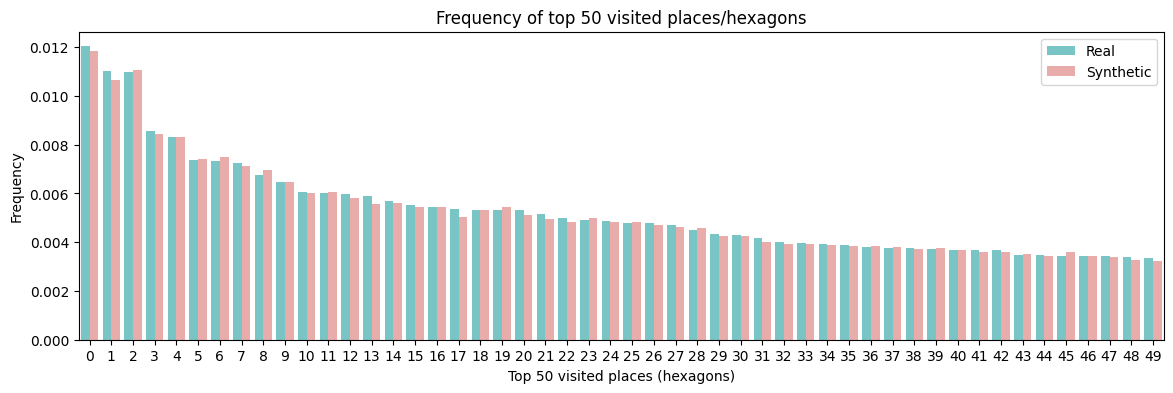

In [42]:
fig, ax = plt.subplots(figsize=(14, 4))
plt.title(f"Frequency of top {TOP_N_PLACES} visited places/hexagons")
plt.xlabel(f"Top {TOP_N_PLACES} visited places (hexagons)")
plt.ylabel("Frequency")
sns.barplot(x='n_hexagon', y='n_points', hue='data', data=top_n_hexagons_df_chart.sort_values(['data', 'n_points'], ascending=[True, False]), palette=['#6CD1D2', '#F3A29F'])
plt.legend(title='')
plt.show()

In [25]:
# Calculate hotspot difference between real and synthetic data (Mean absolute difference between real and synthetic data in top N visited places)
hotspot_difference = top_n_hexagons_df['n_points_real_relative'] - top_n_hexagons_df['n_points_synthetic_relative']
hotspot_difference = hotspot_difference.abs()
hotspot_difference = hotspot_difference.sum() / TOP_N_PLACES
hotspot_difference

9.290609170836812e-05

In [26]:
hexbins_df_category = hexbins_df.copy()[['coordinates', 'n_points_real_category', 'n_points_real']]

In [27]:
hexbins_df_category['polygons_plotly'] = hexbins_df_category['coordinates'].apply(lambda x: Polygon([[y[1], y[0]] for y in x]))
hexbins_df_category['index'] = hexbins_df_category.index

In [28]:
hexbins_df_category.sample(5)

,coordinates,n_points_real_category,n_points_real,polygons_plotly,index
1254,"[[41.23978026326886, -8.609618970037635], [41....",less-visited,18,POLYGON ((-8.609618970037635 41.23978026326886...,1254
192,"[[41.17672826107967, -8.679512430177423], [41....",less-visited,77,POLYGON ((-8.679512430177423 41.17672826107967...,192
220,"[[41.21176465258105, -8.676824220172048], [41....",less-visited,4,POLYGON ((-8.676824220172048 41.21176465258105...,220
4908,"[[41.157450253101146, -8.554510664927419], [41...",less-visited,114,POLYGON ((-8.554510664927419 41.15745025310114...,4908
4217,"[[41.11887722300441, -8.600210235018817], [41....",less-visited,498,POLYGON ((-8.600210235018817 41.11887722300441...,4217


In [29]:
geojson_real_category = hexagons_dataframe_to_geojson(hexbins_df_category, 'index', 'polygons_plotly', 'n_points_real_category')

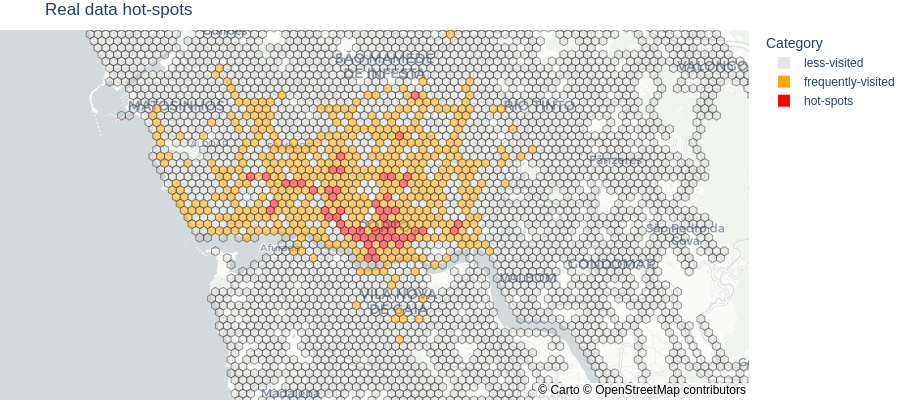

In [30]:
fig_hexa_real_category = px.choropleth_mapbox(
    hexbins_df_category, geojson=geojson_real_category, locations='index', color='n_points_real_category',
    color_discrete_map={"hot-spots": "red", "frequently-visited": "orange", "less-visited": "rgba(0,0,0,0.1)"},
    mapbox_style="carto-positron",
    zoom=11, center = {"lat": 41.15220, "lon": -8.61414},
    opacity=0.5,
    title=f'Real data hot-spots',
    hover_data={'n_points_real': True, 'n_points_real_category': False, 'index': False},
    width=900,
    height=400,
    labels={'n_points_real_category':'Category'},
)
fig_hexa_real_category.update_layout(margin=dict(b=0, t=30, l=0, r=0))
# fig_hexa_real_category.show()
png_hexa_real_category = fig_hexa_real_category.to_image(format="png", width=900, height=400, scale=1)
Image(png_hexa_real_category)

## Accuracy on Trip-Level

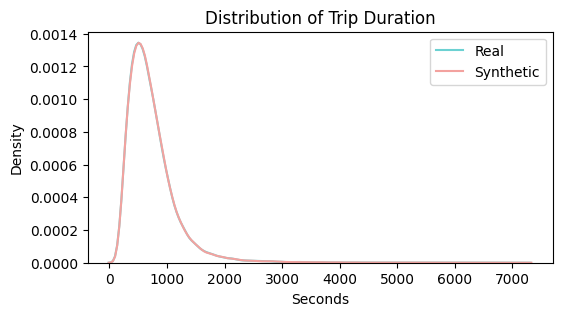

In [31]:
# Plot distribution of trip duration
fig, ax = plt.subplots(figsize=(6, 3))
plt.title("Distribution of Trip Duration")
plt.xlabel("Seconds")
plt.ylabel("Density")
sns.kdeplot(df_real["TRIP_DURATION"], label="Real", color="#6CD1D2", ax=ax)
sns.kdeplot(df_synthetic["TRIP_DURATION"], label="Synthetic", color="#F3A29F", ax=ax)
plt.legend()
plt.show()

In [32]:
# Calculate probability distribution of trip duration
bins = np.linspace(0, df_real["TRIP_DURATION"].max(), 100)
real_duration_prob, _ = np.histogram(df_real["TRIP_DURATION"], bins=bins, density=True)
synthetic_duration_prob, _ = np.histogram(df_synthetic["TRIP_DURATION"], bins=bins, density=True)

# Calculate Jensen-Shannon divergence
jsd_duration = jensenshannon(real_duration_prob, synthetic_duration_prob)
jsd_duration

0.011411990277801017

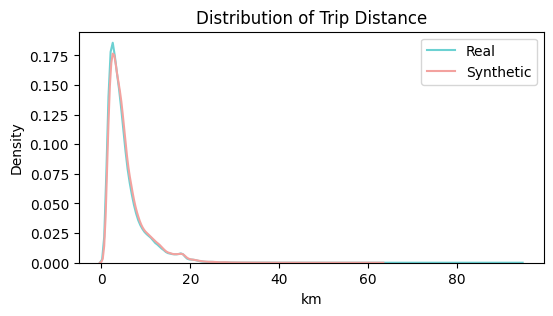

In [33]:
# Plot distribution of trip distance
fig, ax = plt.subplots(figsize=(6, 3))
plt.title("Distribution of Trip Distance")
plt.xlabel("km")
plt.ylabel("Density")
sns.kdeplot(df_real["TRIP_DISTANCE"] / 1000, label="Real", color="#6CD1D2", ax=ax)
sns.kdeplot(df_synthetic["TRIP_DISTANCE"] / 1000, label="Synthetic", color="#F3A29F", ax=ax)
plt.legend()
plt.show()

In [34]:
# Calculate probability distribution of trip distance
bins = np.linspace(0, df_real["TRIP_DISTANCE"].max(), 100)
real_distance_prob, _ = np.histogram(df_real["TRIP_DISTANCE"], bins=bins, density=True)
synthetic_distance_prob, _ = np.histogram(df_synthetic["TRIP_DISTANCE"], bins=bins, density=True)

# Calculate Jensen-Shannon divergence
jsd_distance = jensenshannon(real_distance_prob, synthetic_distance_prob)
jsd_distance

0.036084678427482426

In [35]:
# Calculate the straightness index of the trips (ratio of the origin-destination distance to the full traveled distance)
df_real['OD_DISTANCE'] = df_real.apply(lambda x: hs.haversine(eval(x['START_POSITION']), eval(x['END_POSITION']), unit=Unit.METERS), axis=1)
df_real['STRAIGHTNESS_INDEX'] = df_real['OD_DISTANCE'] / df_real['TRIP_DISTANCE']
df_synthetic['OD_DISTANCE'] = df_synthetic.apply(lambda x: hs.haversine(eval(x['START_POSITION']), eval(x['END_POSITION']), unit=Unit.METERS), axis=1)
df_synthetic['STRAIGHTNESS_INDEX'] = df_synthetic['OD_DISTANCE'] / df_synthetic['TRIP_DISTANCE']

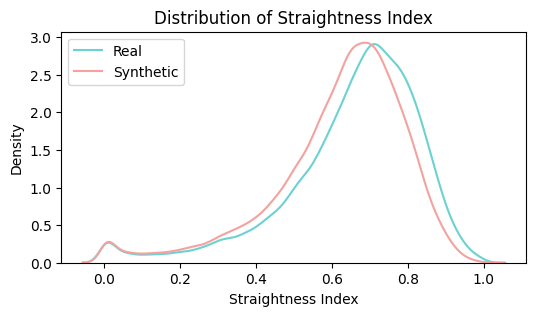

In [36]:
# Plot distribution of straightness index
fig, ax = plt.subplots(figsize=(6, 3))
plt.title("Distribution of Straightness Index")
plt.xlabel("Straightness Index")
plt.ylabel("Density")
sns.kdeplot(df_real["STRAIGHTNESS_INDEX"], label="Real", color="#6CD1D2", ax=ax)
sns.kdeplot(df_synthetic["STRAIGHTNESS_INDEX"], label="Synthetic", color="#F3A29F", ax=ax)
plt.legend()
plt.show()

In [37]:
# Calculate probability distribution of straightness index
bins = np.linspace(0, 1, 100)
real_straightness_prob, _ = np.histogram(df_real["STRAIGHTNESS_INDEX"], bins=bins, density=True)
synthetic_straightness_prob, _ = np.histogram(df_synthetic["STRAIGHTNESS_INDEX"], bins=bins, density=True)

# Calculate Jensen-Shannon divergence
jsd_straightness = jensenshannon(real_straightness_prob, synthetic_straightness_prob)
jsd_straightness

0.09757637293242284

In [38]:
# Calculate the the radius of gyration (measures how far on average the trip is from its center of mass/trip)
def calculate_gyration_radius(polyline, center_of_mass):
    # Convert the polyline and center_of_mass to numpy arrays
    polyline_array = np.array(eval(polyline))
    center_of_mass_array = np.array(center_of_mass)

    # Calculate the distance from each GPS point to the center of mass
    distances = np.array([])
    for point in polyline_array:
        distance = hs.haversine(center_of_mass_array, point, unit=Unit.METERS)
        distances = np.append(distances, distance)

    # Calculate the gyration radius using the formula: sqrt(sum((d_i - d_avg)^2) / n)
    avg_distance = np.mean(distances)
    # squared_distances = (distances - avg_distance) ** 2
    # gyration_radius = np.sqrt(np.sum(squared_distances) / len(polyline))

    return avg_distance

df_real['CENTER_OF_MASS'] = df_real['POLYLINE'].apply(lambda x: np.mean(eval(x), axis=0))
df_real['GYRATION_RADIUS'] = df_real.apply(lambda row: calculate_gyration_radius(row['POLYLINE'], row['CENTER_OF_MASS']), axis=1)
df_real = df_real.drop(columns=['CENTER_OF_MASS'])   

df_synthetic['CENTER_OF_MASS'] = df_synthetic['POLYLINE'].apply(lambda x: np.mean(eval(x), axis=0))
df_synthetic['GYRATION_RADIUS'] = df_synthetic.apply(lambda row: calculate_gyration_radius(row['POLYLINE'], row['CENTER_OF_MASS']), axis=1)
df_synthetic = df_synthetic.drop(columns=['CENTER_OF_MASS'])

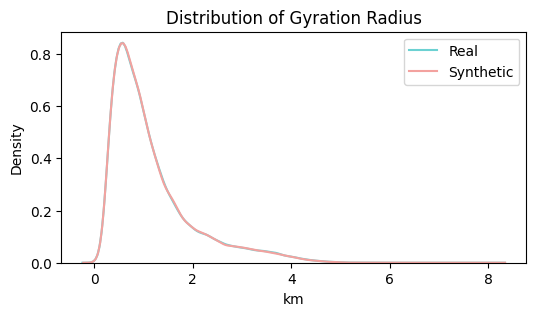

In [39]:
# Plot distribution of gyration radius
fig, ax = plt.subplots(figsize=(6, 3))
plt.title("Distribution of Gyration Radius")
plt.xlabel("km")
plt.ylabel("Density")
sns.kdeplot(df_real["GYRATION_RADIUS"] / 1000, label="Real", color="#6CD1D2", ax=ax)
sns.kdeplot(df_synthetic["GYRATION_RADIUS"] / 1000, label="Synthetic", color="#F3A29F", ax=ax)
plt.legend()
plt.show()

In [40]:
# Calculate probability distribution of gyration radius
bins = np.linspace(0, df_real["GYRATION_RADIUS"].max(), 100)
real_gyration_prob, _ = np.histogram(df_real["GYRATION_RADIUS"], bins=bins, density=True)
synthetic_gyration_prob, _ = np.histogram(df_synthetic["GYRATION_RADIUS"], bins=bins, density=True)

# Calculate Jensen-Shannon divergence
jsd_gyration = jensenshannon(real_gyration_prob, synthetic_gyration_prob)
jsd_gyration

0.010009891602871867

In [41]:
# Create metrics dataframe
metrics = pd.DataFrame({
    "Hotspot Difference": [hotspot_difference],
    "JSD Duration": [jsd_duration],
    "JSD Distance": [jsd_distance],
    "JSD Straightness": [jsd_straightness],
    "JSD Gyration": [jsd_gyration],
})
metrics

,Hotspot Difference,JSD Duration,JSD Distance,JSD Straightness,JSD Gyration
0,0.000093,0.011412,0.036085,0.097576,0.01001
